# Automatisierte Lösung für OpenAIs LunarLander mit genetischen Algorithmen

@Autor Michael Greif

## Benutzte Bibliotheken

Bibliotheksreferenzen
- OpenAI Gymnasium: https://gymnasium.farama.org/
- NumPy: https://numpy.org/
- Matplotlib: https://matplotlib.org/

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

## Training

Im Training wird mit genetischen Algorithmen ein kleines Modell zum Spielen der Anwendung aufgebaut

### Parameter der genetischen Algorithmen

Diese Parameter bieten eine grundlegende Steuerung, wie der genetische Algorithmus die Suche nach optimalen Lösungen durchführt. Anpassungen dieser Parameter können dazu beitragen, dass der Algorithmus entweder schneller konvergiert oder diverser erkundet, je nach Anwendungsfall

In [2]:
population_size = 100 # Anzahl der Individuen in der Population
num_generations = 50 # Anzahl der Generationen, die der Algorithmus durchläuft
mutation_rate = 0.1 # Wahrscheinlichkeit, mit der eine Mutation auftritt
elitism_size = int(0.1 * population_size) # Anzahl der besten Individuen, die unverändert in die nächste Generation übergehen

### Funktionen für die Erstellung der gentischen Algorithmen

Die Funktion `evaluate` bewertet die Eignung eines Individuums über mehrere Episoden in einer Gym-Umgebung. Ein Gewichtungsvektor bestimmt dabei die Aktionen basierend auf dem aktuellen Zustand, indem das Skalarprodukt berechnet und die Aktion mit dem höchsten Wert ausgewählt wird. Die durchschnittliche Belohnung über die gewählten Episoden wird zurückgegeben, was eine konsistentere Beurteilung ermöglicht. Allerdings folgt die Anzahl der Episoden einer Sättigungskurve, die den Gewinn von zusätzlicher Konsistenz mit steigendem Rechenaufwand ins Gleichgewicht bringt.

Die Funktion `mutate` führt zufällige Änderungen am Gewichtungsvektor eines Individuums durch. Mit einer Wahrscheinlichkeit, die durch den Mutationsgrad definiert wird, wird jedem einzelnen Element im Vektor ein kleiner zufälliger Wert, der aus einer Normalverteilung stammt, hinzugefügt. Diese Mutationen erhalten die genetische Vielfalt innerhalb der Population aufrecht und verhindern eine zu frühe Konvergenz auf lokale Optima.

Die Funktion `crossover` kombiniert zwei Eltern-Individuen, um ein neues Kind zu erzeugen. Die Methode verwendet einen Einfachpunkt-Crossover-Ansatz, bei dem ein zufälliger Punkt entlang der Länge der Elternvektoren bestimmt wird. Das Kind erbt die ersten Elemente des ersten Elternteils und die verbleibenden vom zweiten Elternteil. Diese Kombination ermöglicht das Erforschen des Lösungsraums durch Mischen der Eigenschaften beider Eltern und erhöht dadurch die Wahrscheinlichkeit, nützliche Merkmale weiterzugeben.

In [3]:
def evaluate(individual, env, num_episodes=10):
    """
    Bewertet ein Individuum über mehrere Episoden.
    
    Parameters:
    - individual: Ein Gewichtungsvektor zur Entscheidung über Aktionen.
    - train_env: Die Gym-Umgebung, in der die Bewertung stattfindet.
    - num_episodes: Die Anzahl von Episoden zur Bewertung eines Individuums. Desto größer dieser Wert, desto konsistentere Ergebnise werden erzielt. Jedoch folgt diese Varibale einer Sättigungskurve!
    
    Returns:
    - Durchschnittliche Belohnung über die gewählten Episoden hinweg.
    """
    total_reward = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        for _ in range(1000):
            action = np.argmax(np.dot(state, individual))
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            if terminated or truncated:
                break
        total_reward += episode_reward
    return total_reward / num_episodes

def mutate(individual):
    """
    Führt Mutationen an einem Individuum durch.
    
    Parameters:
    - individual: Ein zu mutierender Gewichtungsvektor.
    
    Returns:
    - Mutiertes Individuum.
    """
    for i in range(individual.shape[0]):
        for j in range(individual.shape[1]):
            if np.random.rand() < mutation_rate:
                individual[i, j] += np.random.normal(0, 1)
    return individual

def crossover(parent1, parent2):
    """
    Kombiniert zwei Eltern zu einem Kind.
    
    Parameters:
    - parent1: Erster Elterngewichtungsvektor.
    - parent2: Zweiter Elterngewichtungsvektor.
    
    Returns:
    - Kind, eine Mischung der beiden Elternteile.
    """
    crossover_point = np.random.randint(parent1.shape[0])
    child = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    return child

## Trainingsphase

Zu Beginn wird die Gym-Umgebung `LunarLander-v3` erstellt, mit einer modifizierten Schwerkraft, die das Verhalten des Landers beeinflusst. Die anfängliche Population besteht aus zufälligen Gewichtungsvektoren, die die Aktionen des Landers steuern. Für jede Generation wird die Population evaluiert, indem die `evaluate`-Funktion für jedes Individuum aufgerufen wird, um deren Leistung (Score) zu messen.

Um die besten Individuen zu identifizieren, werden die Scores in absteigender Reihenfolge sortiert und die individuellen Lösungen entsprechend neu angeordnet. Elitismus wird umgesetzt, indem die besten Individuen direkt in die nächste Generation übernommen werden, was gewährleistet, dass Spitzenlösungen erhalten bleiben.

Für die Erzeugung neuer Individuen in der Population werden Eltern zufällig aus der besten Hälfte der aktuellen Population ausgewählt. Diese Eltern durchlaufen die `crossover`- und `mutate`-Funktionen, um neue Nachkommen zu erzeugen. Dieses Vorgehen stellt sicher, dass die nächste Generation sowohl erfolgreiche Merkmale der Eltern als auch neue Eigenschaften durch Mutation aufweist.

Am Ende des Trainings wird das beste Individuum der letzten Generation gespeichert, um seine Strategie für zukünftige Verwendungen zugänglich zu machen. Die gesamte Entwicklung des besten Scores über die Generationen hinweg wird in der Variablen `best_scores` festgehalten, welches potentiell nützliche Daten für die Analyse der Fortschritte des Algorithmus liefert.

In [4]:
def genetic_algorithm():
    """
    Führt den genetischen Algorithmus zur Optimierung durch.
    """
    env = gym.make('LunarLander-v3', gravity=-10.0, render_mode=None)
    best_scores = []
    
    # Initialisierung der Bevölkerung mit zufälligen Individuen
    population = [np.random.rand(env.observation_space.shape[0], env.action_space.n) for _ in range(population_size)]
    
    for generation in range(num_generations):
        # Bewertung der aktuellen Population
        scores = np.array([evaluate(individual, env) for individual in population])
        
        # Auswahl der besten Individuen (Elitismus)
        sorted_indices = np.argsort(scores)[::-1]
        population = [population[i] for i in sorted_indices]
        scores = scores[sorted_indices]

        best_score = scores[0]
        best_scores.append(best_score)
        print(f"Generation {generation}: Best Score = {best_score}")

        # Selektion und Erzeugung der nächsten Generation
        new_population = population[:elitism_size]  # Beste Individuen übernehmen

        while len(new_population) < population_size:
            parent_indices = np.random.choice(population_size // 2, 2, replace=False)
            parent1, parent2 = population[parent_indices[0]], population[parent_indices[1]]
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        population = new_population

    # Ausgabe des besten Individuums am Ende
    best_individual = population[0]

    # Speichern der besten Strategie
    np.save('best_strategy.npy', best_individual)
    
    return best_scores

best_scores = genetic_algorithm()

Generation 0: Best Score = -94.56800353092856
Generation 1: Best Score = -85.36592418097973
Generation 2: Best Score = -45.639898341924514
Generation 3: Best Score = -41.78572179132808
Generation 4: Best Score = -13.500506256289583
Generation 5: Best Score = -16.291277508936098
Generation 6: Best Score = -26.0021688140259
Generation 7: Best Score = -13.794667879766234
Generation 8: Best Score = 69.8440611740028
Generation 9: Best Score = 76.02492976510071
Generation 10: Best Score = 87.90155566441905
Generation 11: Best Score = 68.28947089363481
Generation 12: Best Score = 75.29051313424534
Generation 13: Best Score = 89.2360998922668
Generation 14: Best Score = 178.16187763014645
Generation 15: Best Score = 106.17679402997749
Generation 16: Best Score = 139.0583598315489
Generation 17: Best Score = 150.7600185589043
Generation 18: Best Score = 201.72886659784243
Generation 19: Best Score = 230.33516568186965
Generation 20: Best Score = 240.32288204220305
Generation 21: Best Score = 23

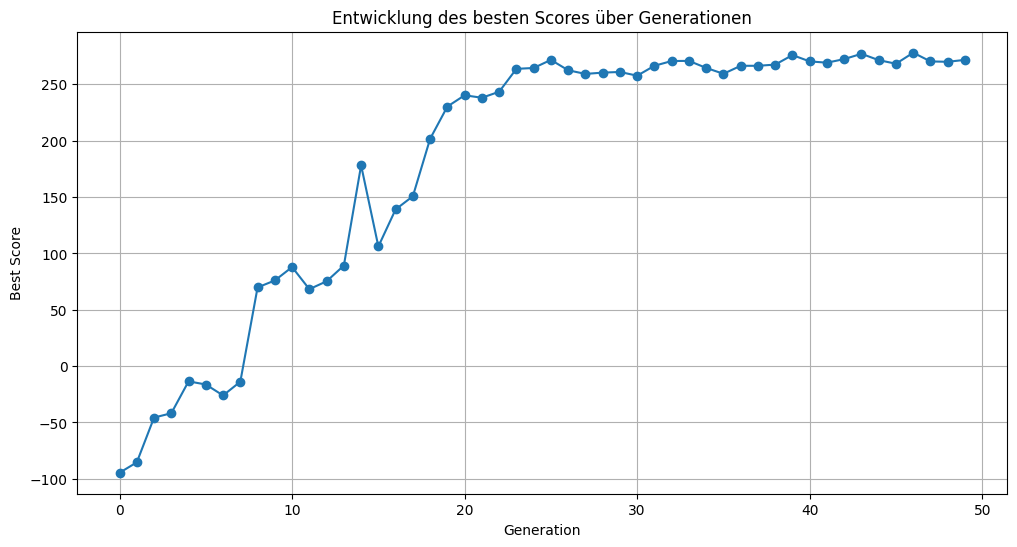

In [5]:
# Plot: des Lernfortschritts
plt.figure(figsize=(12, 6))
plt.plot(range(num_generations), best_scores, marker='o')
plt.title('Entwicklung des besten Scores über Generationen')
plt.xlabel('Generation')
plt.ylabel('Best Score')
plt.grid()
plt.show()

Der Plot veranschaulicht den Lernfortschritt des genetischen Algorithmus während des Trainingsprozesses. Im Diagramm wird die Entwicklung des besten Scores über die verschiedenen Generationen gezeigt. Die X-Achse stellt die Anzahl der Generationen dar, während die Y-Achse den besten Score innerhalb jeder Generation darstellt.

Zu Beginn sind die Scores niedrig, was darauf hindeutet, dass die anfänglichen zufälligen Individuen in der Population nicht optimal performen. Im Laufe der Generationen ist ein deutlicher Anstieg der Scores zu erkennen, was auf eine Verbesserung der Lösungen hindeutet, die durch den genetischen Algorithmus gefunden werden. Diese Steigerung resultiert aus der kontinuierlichen Anwendung von Selektion, Kreuzung und Mutation, die es der Population ermöglicht, sich hin zu besseren Lösungen zu entwickeln.

In den späteren Generationen zeigt der Plot eine Stabilisierung der Scores, was darauf hindeutet, dass der Algorithmus zu einer konvergierenden Lösung tendiert. Diese Stabilisierung deutet darauf hin, dass der Algorithmus möglicherweise ein hohes Maß an Optimierung für die gegebene Aufgabe erreicht hat.

## Evaluation

Die `load_and_run`-Funktion dient der Evaluation der besten Strategie, die zuvor während des Trainingsprozesses mittels des genetischen Algorithmus ermittelt und gespeichert wurde. Diese Funktion ermöglicht es, die Leistung der optimierten Steuerstrategie über eine Reihe von Episoden zu testen und die durchschnittliche Leistung zu beurteilen.

Zunächst wird die beste Strategie aus einer gespeicherten Datei geladen. Anschließend wird die Gym-Umgebung `LunarLander-v3` mit einem speziellen Gravitationswert eingerichtet. Der Parameter `render_mode` steuert, ob die Umgebung visuell dargestellt wird, was für ein tieferes Verständnis des Verhaltens hilfreich sein kann oder zu Debugging-Zwecken dient.

Für die spezifizierte Anzahl von Episoden (`n_times`) wird die Umgebung wiederholt durchlaufen:

1. **Initialisierung**: Der Spielzustand wird zurückgesetzt, und eine zufällige Saat wird verwendet, um die Konsistenz und Vielfalt in den evaluierenden Durchgängen zu gewährleisten.

2. **Ausführung der Strategie**: In jedem Schritt wird eine Aktion basierend auf der aktuellen besten Strategie (über das maximale Skalarprodukt) ausgewählt und ausgeführt. Die Reaktion der Umgebung, einschließlich Belohnung und aktueller Spielzustand, wird gesammelt.

3. **Erfassung der Ergebnisse**: Bei jeder Episode wird die kumulative Belohnung gemessen, ebenso wird der Fehler hinsichtlich der Zielabweichung auf der horizontalen Achse (`state[0]`) verfolgt. Diese Informationen bieten Einblick in die Präzision der Landung.

Am Ende werden die Ergebnisse der fünf Episoden, wie die durchschnittliche Belohnung und die mittlere Abweichung auf der horizontalen Achse, auf der Konsole ausgegeben. Diese Metriken geben Auskunft über die Effektivität der Steuerstrategie und deren Präzisionsgrad beim Landen in der Zielzone. Die gesamte Umgebung wird nach Abschluss der Auswertung sauber geschlossen.

In [6]:
def load_and_run(n_times=10, render_mode="human"):
    """
    Lädt die beste Strategie und führt sie in der Umgebung aus.
    
    Parameters:
    - n_times: Anzahl der Episoden, die gespielt werden sollen.
    - render_mode: Modus zur Visualisierung der Umgebung.
    """
    
    # Beste Strategie laden
    best_strategy = np.load('best_strategy.npy')
    play_env = gym.make('LunarLander-v3', gravity=-10.0, render_mode=render_mode)
    total_rewards = []
    err = []
    
    for episode in range(n_times):
        state, _ = play_env.reset(seed=np.random.randint(0, 10000))
        total_reward = 0
        for _ in range(1000):
            action = np.argmax(np.dot(state, best_strategy))
            state, reward, terminated, truncated, _ = play_env.step(action)
            total_reward += reward
            if terminated or truncated:
                break
        total_rewards.append(total_reward)
        err.append(abs(state[0]))
        print(f"Episode {episode + 1}: Score = {total_reward:.4f}, Error = {state[0]:.2f}")
        
    print(f"\nAverage Score over {n_times} episodes: {np.mean(total_rewards):.4f} with mean error from x = 0: {np.mean(err):.2f}")
    play_env.close()
    
load_and_run(n_times=1000, render_mode=None)

Episode 1: Score = 303.9389, Error = 0.06
Episode 2: Score = 244.6350, Error = 0.02
Episode 3: Score = 68.9746, Error = 0.00
Episode 4: Score = 248.2600, Error = 0.06
Episode 5: Score = 260.7794, Error = 0.01
Episode 6: Score = 297.1496, Error = -0.01
Episode 7: Score = 235.7126, Error = 0.01
Episode 8: Score = 281.8366, Error = 0.09
Episode 9: Score = 245.5447, Error = 0.00
Episode 10: Score = 262.9700, Error = -0.00
Episode 11: Score = 237.5323, Error = -0.02
Episode 12: Score = 1.9109, Error = 0.19
Episode 13: Score = 246.6051, Error = 0.04
Episode 14: Score = 218.6500, Error = -0.00
Episode 15: Score = 229.7211, Error = -0.02
Episode 16: Score = 260.9712, Error = -0.02
Episode 17: Score = 236.4974, Error = 0.04
Episode 18: Score = 240.3764, Error = 0.00
Episode 19: Score = 292.9624, Error = 0.04
Episode 20: Score = 28.2503, Error = 0.20
Episode 21: Score = 243.8816, Error = -0.03
Episode 22: Score = 264.6862, Error = 0.06
Episode 23: Score = 252.5470, Error = 0.03
Episode 24: Score

Hier kann natürlich auch mit dem menschlichen Auge beispielsweise zehn Landungen simuliert und ausgegeben werden.

In [7]:
# Test mit human Render-Mode
load_and_run(10,"human")

Episode 1: Score = 301.4981, Error = 0.05
Episode 2: Score = 260.9985, Error = -0.02
Episode 3: Score = 316.3073, Error = 0.09
Episode 4: Score = 216.3746, Error = 0.07
Episode 5: Score = 245.4493, Error = 0.02
Episode 6: Score = 286.8762, Error = 0.09
Episode 7: Score = 252.6290, Error = -0.02
Episode 8: Score = 234.6814, Error = -0.02
Episode 9: Score = 300.1256, Error = 0.05
Episode 10: Score = 234.2435, Error = -0.02

Average Score over 10 episodes: 264.9184 with mean error from x = 0: 0.04


## Fazit

Der Einsatz von genetischen Algorithmen hat sich als eine effektive Methode zur Optimierung der Steuerstrategie erwiesen. Durch systematisches Durchlaufen von Selektion, Kreuzung und Mutation über mehrere Generationen hinweg konnte eine Strategie entwickelt werden, die weit über dem Minimum von 200 Punkten liegt, das für eine erfolgreiche Landung benötigt wird.

Mit einer durchschnittlichen Punktzahl, die um ca. 50 Punkte über dem erforderlichen Grenzwert liegt, demonstriert deine Methode nicht nur die Fähigkeit zur erfolgreichen Landung, sondern auch eine hohe Effizienz und Präzision. Solche positiven Ergebnisse unterstreichen die Effektivität genetischer Algorithmen bei der Lösung komplexer Optimierungsprobleme, insbesondere in dynamischen und oft unvorhersehbaren Umgebungen wie der erkundeten.